In [1]:
import glob
import os
from os import walk
import tensorflow as tf
import cv2
import keras
from keras import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.cross_validation import train_test_split
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
%matplotlib inline

/home/sagar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/sagar/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_dataset_dir = "/media/sagar/D/ctranz/newDataset/train"
test_dataset_dir = "/media/sagar/D/ctranz/newDataset/validate"
img_size = 224
img_channels = 3
num_classes = 4
data_dict = {'data':None, 'labels':[], 'image_path':[]}
#Load the ResNet50 model
#resnet_model = resnet50.ResNet50(weights='imagenet')

In [3]:
batch_size = 60
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

#img = load_img('/media/sagar/D/ctranz/newDataset/test/SUV00.jpg')  # this is a PIL image
#x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
#x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
#print(x.shape)
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
        
        
        
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                                    train_dataset_dir,
                                    target_size=(img_size,img_size),
                                    batch_size=batch_size,
                                    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
                                    test_dataset_dir,
                                    target_size=(img_size,img_size),
                                    batch_size=batch_size,
                                    class_mode='categorical')

Found 277 images belonging to 4 classes.
Found 67 images belonging to 4 classes.


In [4]:
input_shape = (224,224,3)
base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=input_shape)
#base_model.summary()
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(base_model).create(prog='dot', format='svg'))

In [5]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from resnet50. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(base_model.layers):
 #  print(i, layer.name)

In [6]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from resnet50. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:

nclass =4
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.models import Model
#x = base_model.output
#x = Flatten()(x)
#predictions = Dense(3, activation='softmax', name='predictions')(x)
#x = GlobalAveragePooling2D()(x)
#x = Dense(1024, activation='relu')(x)
#predictions = Dense(5,activation='softmax')(x)
#x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
#predictions = Dense(4, activation='softmax')(x)
add_model = Sequential()
base_model.trainable = False
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
#add_model.add(Flatten())
#add_model.add(Dropout(0.8))
#add_model.add(Dense(4000, activation='relu'))
#add_model.add(Dropout(0.5))
add_model.add(Dense(1024, activation='relu'))
add_model.add(Dense(512, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass,activation='softmax'))
model = add_model

#model = Model(inputs=base_model.input,outputs=predictions)

#for i, layer in enumerate(model.layers):
#   print(i, layer.name)

In [7]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
#for layer in base_model.layers:
#    layer.trainable = False
from keras.optimizers import Adam
#Adam = optimizers.Adam(lr=0.001)
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()
#print(model.summary())

In [10]:
history = model.fit_generator(train_generator, steps_per_epoch=None, epochs=25, verbose=2, callbacks=None, validation_data=validation_generator, validation_steps=None, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=True, shuffle=True, initial_epoch=20)

Epoch 21/25
 - 33s - loss: 0.7873 - acc: 0.7040 - val_loss: 1.2264 - val_acc: 0.4478
Epoch 22/25
 - 35s - loss: 0.7348 - acc: 0.6633 - val_loss: 1.1664 - val_acc: 0.6418
Epoch 23/25
 - 32s - loss: 0.7548 - acc: 0.6988 - val_loss: 1.4431 - val_acc: 0.4328
Epoch 24/25
 - 34s - loss: 0.8825 - acc: 0.6346 - val_loss: 0.8383 - val_acc: 0.6567
Epoch 25/25
 - 33s - loss: 0.7914 - acc: 0.6785 - val_loss: 0.7930 - val_acc: 0.7015


In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from resnet50. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(model.layers):
#   print(i, layer.name)
#model.fit_generator(train_generator, steps_per_epoch=None, epochs=50, verbose=2, callbacks=None, validation_data=test_generator, validation_steps=None, class_weight=None, max_queue_size=10, workers=4, use_multiprocessing=True, shuffle=True, initial_epoch=30)

In [12]:
for layer in model.layers[:150]:
    layer.trainable = False
for layer in model.layers[150:]:
    layer.trainable = True
from keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history1 = model.fit_generator(train_generator, steps_per_epoch=None, epochs=20, verbose=2, callbacks=None, validation_data=validation_generator, validation_steps=None, class_weight=None, max_queue_size=10, workers=4, use_multiprocessing=True, shuffle=True, initial_epoch=0)


Epoch 1/20
 - 37s - loss: 0.7017 - acc: 0.7123 - val_loss: 0.8644 - val_acc: 0.6418
Epoch 2/20
 - 36s - loss: 0.7043 - acc: 0.7292 - val_loss: 0.7259 - val_acc: 0.6866
Epoch 3/20
 - 34s - loss: 0.6831 - acc: 0.7327 - val_loss: 0.7834 - val_acc: 0.6567
Epoch 4/20
 - 35s - loss: 0.6562 - acc: 0.7496 - val_loss: 0.8030 - val_acc: 0.6716
Epoch 5/20
 - 35s - loss: 0.7483 - acc: 0.6921 - val_loss: 0.9010 - val_acc: 0.6269
Epoch 6/20
 - 33s - loss: 0.6916 - acc: 0.7173 - val_loss: 0.7837 - val_acc: 0.7015
Epoch 7/20
 - 34s - loss: 0.7482 - acc: 0.6905 - val_loss: 0.7593 - val_acc: 0.6716
Epoch 8/20
 - 34s - loss: 0.7131 - acc: 0.7411 - val_loss: 0.8461 - val_acc: 0.6269
Epoch 9/20
 - 35s - loss: 0.7307 - acc: 0.7173 - val_loss: 0.7619 - val_acc: 0.6418
Epoch 10/20
 - 36s - loss: 0.6970 - acc: 0.7073 - val_loss: 0.8261 - val_acc: 0.6866
Epoch 11/20
 - 35s - loss: 0.6847 - acc: 0.7360 - val_loss: 0.7720 - val_acc: 0.6269
Epoch 12/20
 - 34s - loss: 0.7441 - acc: 0.6834 - val_loss: 0.7578 - val_a

In [ ]:
#history = model.fit_generator(train_generator, steps_per_epoch=None, epochs=30, verbose=2, callbacks=None, validation_data=validation_generator, validation_steps=None, class_weight=None, max_queue_size=10, workers=4, use_multiprocessing=True, shuffle=True, initial_epoch=20)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
{'SUV': 0, 'car': 1, 'pickup': 2, 'truck': 3}


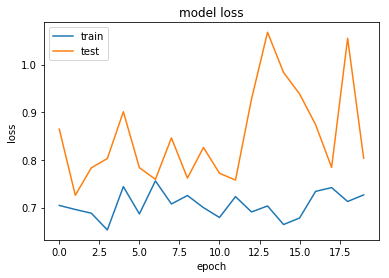

In [13]:
print(history1.history.keys())
label_map = (train_generator.class_indices)
print(label_map)

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


training_loss = history1.history['loss']
test_loss = history1.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

In [ ]:
img_path = "/media/sagar/D/ctranz/newDataset/test/SUV79.png"
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
print(x.shape)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = model.predict(x)
y_classes = preds.argmax(axis=-1)
print('class:', y_classes)
print('Predicted:', preds)

In [ ]:
model.save('my_model.h5')

In [ ]:
from keras.models import load_model
model = load_model('my_model.h5')